# check amplitude in software (20GSPS)

In [128]:
import csv
import os

import matplotlib.pyplot as plt
import numpy as np
import math

import scipy.signal as signal

# Parameters
top_level=f'{os.getcwd()}/..'
path = f'{top_level}/data/scope_1_1.csv'

data_20gsps = []

with open(path) as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONE)
    for i, row in enumerate(reader):
        data_20gsps.append(float(row[1]))

print(len(data_20gsps))

1000000


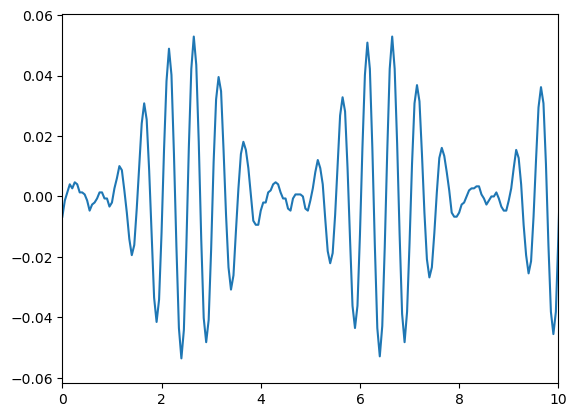

In [129]:
t=np.arange(0,len(data_20gsps))*1000/20000
plt.plot(t,data_20gsps)
plt.xlim(0,10)
plt.show()

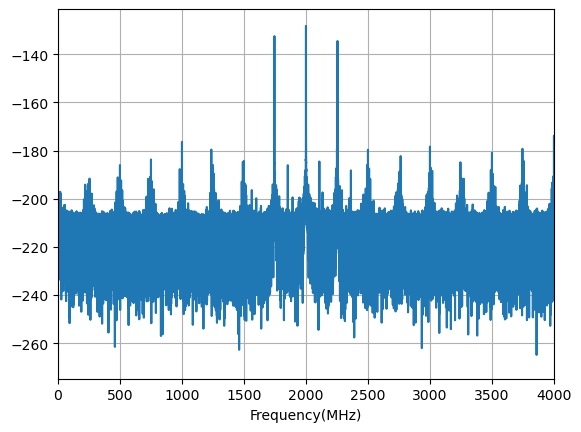

In [130]:
# Calculate the FFT  (full rate)
size    = len(data_20gsps) # Number of data points in the file
timeBin = 0.05 # Unit of ns
freqBin = (0.5E+3/timeBin)/float(size//2) # Units of MHz
freqSteps = np.linspace(0, freqBin*(size//2-1), num=size//2)
freq = np.fft.fft(data_20gsps)/float(len(data_20gsps))
freq = freq[range(len(data_20gsps)//2)]
mag = 20.0*np.log10(np.abs(freq)/32767.0) # Units of dBFS

plt.plot(freqSteps,mag)
plt.xlabel("Frequency(MHz)")
plt.xlim(0,4000)
plt.grid()

In [131]:
h=[-1.6442461318583394e-19,4.3946214368780325e-05,0.000135367210240963,-2.3411031662285917e-19,-0.0006763676753698481,-0.0016998672248677588,-0.001980824432406502,1.6079420504433254e-18,0.004643449916729549,0.009544405332015997,0.009564311653881295,-4.6042828992751135e-18,-0.018223369424618805,-0.035090350353623394,-0.03385851539054352,8.1309439061511e-18,0.06779592549651668,0.1521812648792767,0.22260189734132413,0.2500374529141513,0.22260189734132413,0.1521812648792767,0.06779592549651668,8.1309439061511e-18,-0.03385851539054352,-0.035090350353623394,-0.018223369424618805,-4.6042828992751135e-18,0.009564311653881295,0.009544405332015997,0.004643449916729549,1.6079420504433254e-18,-0.001980824432406502,-0.0016998672248677588,-0.0006763676753698481,-2.3411031662285917e-19,0.000135367210240963,4.3946214368780325e-05,-1.6442461318583394e-19];

In [132]:
#NCO and FIR filter
mixer_frequency = 2e9  # 2 GHz

i_signal = data_20gsps * np.cos(2 * np.pi * mixer_frequency * t * 1e-9)
q_signal = data_20gsps * np.sin(2 * np.pi * mixer_frequency * t * 1e-9)

i_conv = np.convolve(i_signal, h)
q_conv = np.convolve(q_signal, h)

mag=(i_conv**2+q_conv**2)**0.5

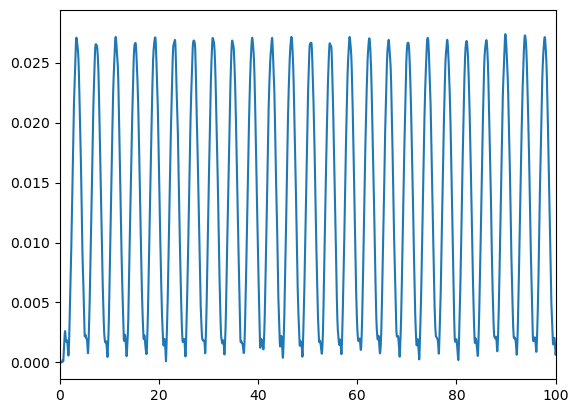

In [133]:
t2=np.arange(0,len(mag))*1000/20000
plt.plot(t2,mag)
plt.xlim(0,100)
plt.show()

In [190]:
#search peak
def peak_search(waveform_data):
    mountain_maxima = []
    
    data_length = len(waveform_data)
    
    noise_threshold = 0.026
    lastindex=0
    for i in range(1, data_length - 1):
        if waveform_data[i] > waveform_data[i - 1] and waveform_data[i] > waveform_data[i + 1]:
            candidate_peak = waveform_data[i]
            
            if candidate_peak > noise_threshold and (i-lastindex) > 60:
                mountain_maxima.append(candidate_peak)
                lastindex=i
        
    return mountain_maxima

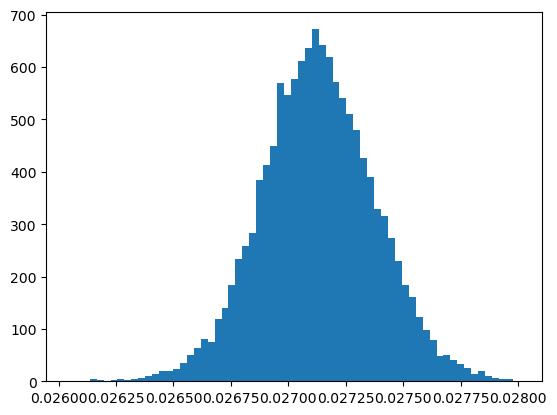

In [191]:
plt.hist(peak_search(mag),bins=65)
plt.show()

# check after downsampling (3.054GSPS)

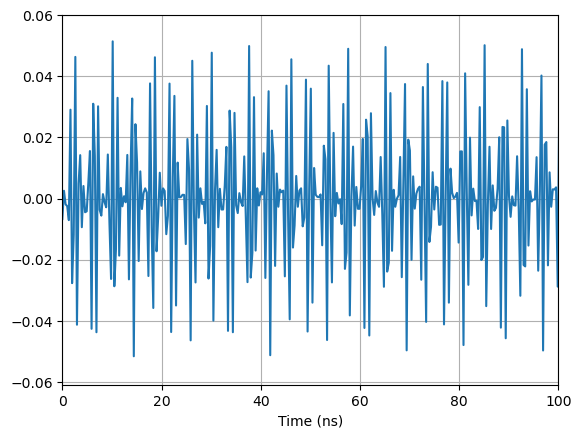

In [202]:
newTimeBin = 1.0/(0.509*6.0) # Unit of ns for 3.054 GSPS
newSize    = 150000

newTimeSteps = np.linspace(0, newTimeBin*(newSize-1), num=newSize)

newWaveform = np.interp(newTimeSteps, t, data_20gsps)
# Plot the time waveform (RFSoC rate)
plt.plot(newTimeSteps,newWaveform)
plt.xlabel("Time (ns)")
plt.xlim(0,100)
plt.grid()

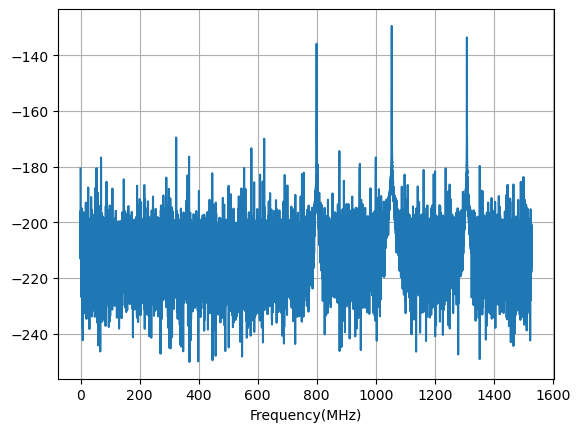

In [204]:
#FFT
size    = len(newWaveform)# Number of data points in the file
timeBin = 1000/3054 # Unit of ns
freqBin = (0.5E+3/timeBin)/float(size//2) # Units of MHz
freqSteps = np.linspace(0, freqBin*(size//2-1), num=size//2)
freq = np.fft.fft(newWaveform)/float(size)
freq = freq[range(size//2)]
mag = 20.0*np.log10(np.abs(freq)/32767.0) # Units of dBFS

plt.plot(freqSteps,mag)
plt.xlabel("Frequency(MHz)")

plt.grid()
plt.show()

In [174]:
#NCO and FIR filter
mixer_frequency_down = 1054e6  

i_signal_down = newWaveform * np.cos(2 * np.pi * mixer_frequency_down * newTimeSteps * 1e-9)
q_signal_down = newWaveform * np.sin(2 * np.pi * mixer_frequency_down* newTimeSteps * 1e-9)

i_conv_down = np.convolve(i_signal_down, h)
q_conv_down = np.convolve(q_signal_down, h)

mag_down=(i_conv_down**2+q_conv_down**2)**0.5

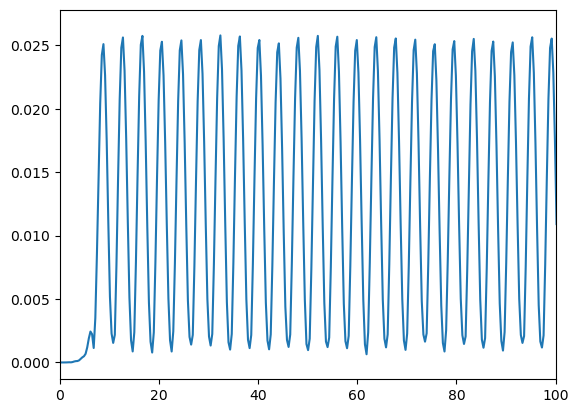

In [175]:
t3=np.arange(0,len(mag_down))*1000/3054
plt.plot(t3,mag_down)
plt.xlim(0,100)
plt.show()

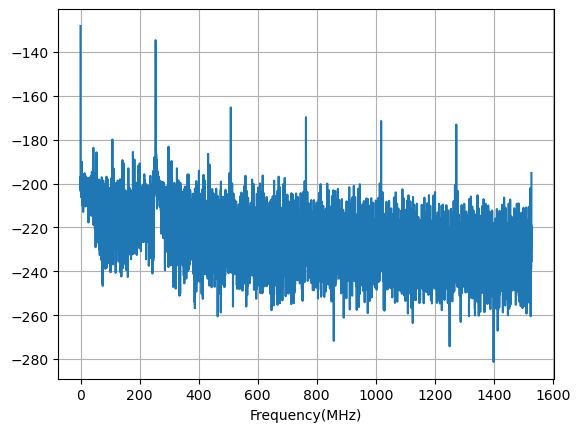

In [206]:
#FFT
size    = len(mag_down)# Number of data points in the file
timeBin = 1000/3054 # Unit of ns
freqBin = (0.5E+3/timeBin)/float(size//2) # Units of MHz
freqSteps = np.linspace(0, freqBin*(size//2-1), num=size//2)
freq = np.fft.fft(mag_down)/float(size)
freq = freq[range(size//2)]
mag = 20.0*np.log10(np.abs(freq)/32767.0) # Units of dBFS

plt.plot(freqSteps,mag)
plt.xlabel("Frequency(MHz)")

plt.grid()
plt.show()

In [196]:
#search peak
def peak_search(waveform_data):
    mountain_maxima = []
    
    data_length = len(waveform_data)
    
    noise_threshold = 0.02
    lastindex=0
    for i in range(1, data_length - 1):
        if waveform_data[i] > waveform_data[i - 1] and waveform_data[i] > waveform_data[i + 1]:
            candidate_peak = waveform_data[i]
            
            if candidate_peak > noise_threshold and (i-lastindex) > 11:
                mountain_maxima.append(candidate_peak)
                lastindex=i
        
    return mountain_maxima

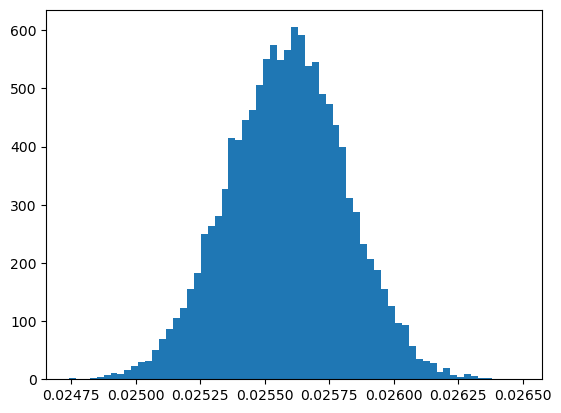

In [197]:
plt.hist(peak_search(mag_down),bins=65)
plt.show()

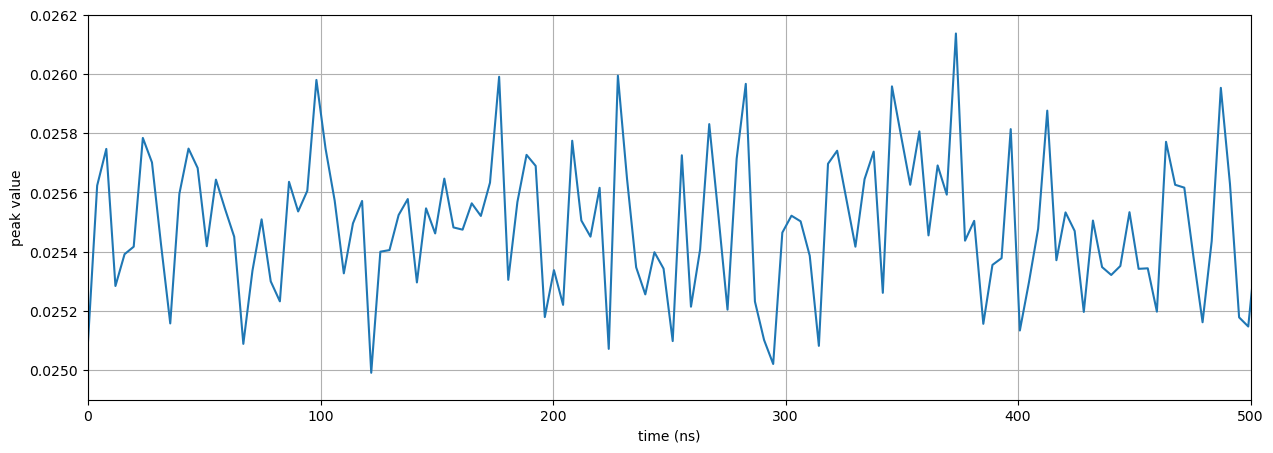

In [212]:
bunch_number=np.arange(0,len(peak_search(mag_down)))*1000/254.5
plt.figure(figsize=(15,5))
plt.plot(bunch_number,peak_search(mag_down))
plt.xlim(0,500)
plt.ylim(0.0249,0.0262)
plt.xlabel("time (ns)")
plt.ylabel("peak value")
plt.grid()
plt.show()

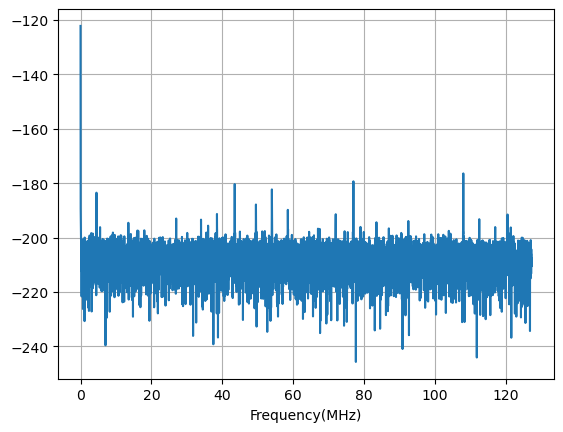

In [205]:
#FFT
size    = len(peak_search(mag_down)) # Number of data points in the file
timeBin = 1000/254.5 # Unit of ns
freqBin = (0.5E+3/timeBin)/float(size//2) # Units of MHz
freqSteps = np.linspace(0, freqBin*(size//2-1), num=size//2)
freq = np.fft.fft(peak_search(mag_down))/float(size)
freq = freq[range(size//2)]
mag = 20.0*np.log10(np.abs(freq)/32767.0) # Units of dBFS

plt.plot(freqSteps,mag)
plt.xlabel("Frequency(MHz)")
#plt.xlim(70,80)
plt.grid()
plt.show()